In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from lightgbm import LGBMRegressor

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, make_scorer


In [13]:
df = pd.read_csv('./data/cleaned_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431001 entries, 0 to 431000
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wind_direction      431001 non-null  float64       
 1   building_id         431001 non-null  int64         
 2   timestamp           431001 non-null  datetime64[ns]
 3   meter_reading       431001 non-null  float64       
 4   primary_use         431001 non-null  object        
 5   square_feet         431001 non-null  int64         
 6   year_built          431001 non-null  int64         
 7   cloud_coverage      431001 non-null  float64       
 8   air_temperature     431001 non-null  float64       
 9   dew_temperature     431001 non-null  float64       
 10  sea_level_pressure  431001 non-null  float64       
 11  wind_speed          431001 non-null  float64       
 12  hour                431001 non-null  int64         
 13  month               431001 no

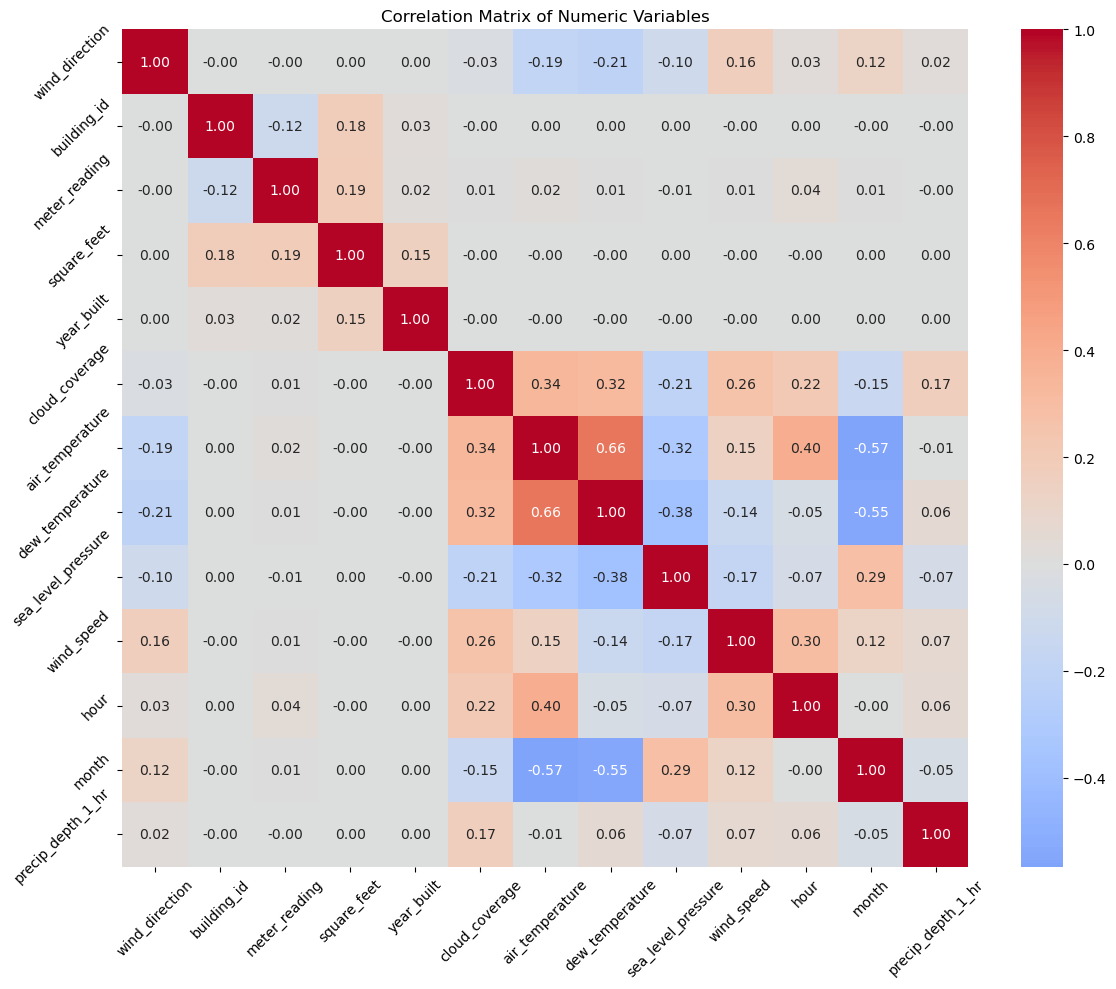

In [14]:

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
train_mask = df.timestamp <  "2016-11-01"
val_mask   = (df.timestamp >= "2016-11-01") & (df.timestamp < "2016-12-01")
test_mask  = df.timestamp >=  "2016-12-01"

df["y_log"] = np.log1p(df["meter_reading"])


In [16]:
# Clipping threshold from train only
P998 = df.loc[train_mask, "meter_reading"].quantile(0.998)

# Apply clipping & spike flag
df["meter_clipped"] = df["meter_reading"].clip(upper=P998)
df["spike_flag"]    = (df["meter_reading"] > P998).astype(int)

In [74]:
WEATHER = [
    "air_temperature",
    "dew_temperature",
    "sea_level_pressure",
    "wind_speed",
    "wind_direction",
    "cloud_coverage",
    "precip_depth_1_hr",
]


def make_features(
    df: pd.DataFrame,
    roll_hrs=(24, 168),
    lag_hrs=(1, 24),
    weather_cols=WEATHER,
):

    df = df.copy()
    ts = df["timestamp"]

    df["hour"]       = ts.dt.hour
    df["weekday"]    = ts.dt.weekday                # 0 = Monday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    df["month"]      = ts.dt.month

    # cyclic encodings
    df["hour_sin"]  = np.sin(2 * np.pi * df["hour"]  / 24)
    df["hour_cos"]  = np.cos(2 * np.pi * df["hour"]  / 24)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    df["log_sqft"]     = np.log1p(df["square_feet"])
    df["building_age"] = ts.dt.year - df["year_built"]

    # categorical dtypes for tree‑boosters
    df["primary_use"] = df["primary_use"].astype("category")
    df["building_id"] = df["building_id"].astype("category")
    df.sort_values(["building_id", "timestamp"], inplace=True)
    grp = df.groupby("building_id", group_keys=False)

    for r in roll_hrs:
         
        df[f"meter_mean_{r}h"] = grp["meter_clipped"].transform(
            lambda x: x.rolling(r, min_periods=1).mean()
        )
        df[f"meter_std_{r}h"] = grp["meter_clipped"].transform(
            lambda x: x.rolling(r, min_periods=1).std()
        ).fillna(0)
        df[f"meter_min_{r}h"] = grp["meter_clipped"].transform(
            lambda x: x.rolling(r, min_periods=1).min()
        )

    for l in lag_hrs:
        df[f"meter_lag_{l}h"] = grp["meter_clipped"].shift(l)

    for col in weather_cols:
        for l in lag_hrs:
            df[f"{col}_lag{l}h"] = grp[col].shift(l)
        for r in roll_hrs:
            df[f"{col}_mean_{r}h"] = grp[col].transform(
                lambda x: x.rolling(r, min_periods=1).mean()
            )
    df["meter_last_week"] = (
    df.groupby("building_id")["meter_clipped"]
      .shift(24 * 7)                                   # 24 h × 7 d
      .fillna(df["meter_clipped"].median())      # fallback
)

    feature_cols = (
        ["hour_sin", "hour_cos", "weekday", "is_weekend",
         "month_sin", "month_cos"] +
        ["log_sqft", "building_age"] +
        weather_cols +
        [f"{c}_lag{l}h"   for c in weather_cols for l in lag_hrs] +
        [f"{c}_mean_{r}h" for c in weather_cols for r in roll_hrs] +
        [f"meter_lag_{l}h"  for l in lag_hrs] +
        [f"meter_mean_{r}h" for r in roll_hrs] +
        [f"meter_std_{r}h"  for r in roll_hrs] +
        [f"meter_min_{r}h"  for r in roll_hrs] +
        ["meter_last_week"] +
        (["spike_flag"] if "spike_flag" in df.columns else []) +
        ["primary_use", "building_id"]
    )

    return df[feature_cols]


In [75]:

# df = df.sort_values(["building_id", "timestamp"])

# df["meter_last_week"] = (
#     df
#       .groupby("building_id")["meter_clipped"]
#       .shift(24 * 7)                                   # 24 h × 7 d
#       .fillna(df["meter_clipped"].median())      # fallback
# )

X_train, y_train = make_features(df.loc[train_mask]), df.loc[train_mask, "y_log"]
X_val,   y_val   = make_features(df.loc[val_mask]),   df.loc[val_mask,   "y_log"]
X_test,  y_test  = make_features(df.loc[test_mask]),  df.loc[test_mask,  "y_log"]

/var/folders/ts/psxn0c916x742nmz5611c5680000gn/T/ipykernel_34160/3491141994.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("building_id", group_keys=False)
/var/folders/ts/psxn0c916x742nmz5611c5680000gn/T/ipykernel_34160/3491141994.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("building_id")["meter_clipped"]
/var/folders/ts/psxn0c916x742nmz5611c5680000gn/T/ipykernel_34160/3491141994.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

In [76]:
cat_cols = [c for c in X_train.columns if X_train[c].dtype.name == "category"]
cat_cols

['primary_use', 'building_id']

In [ ]:
lgbm = lgb.LGBMRegressor(
    objective          = "tweedie",
    tweedie_variance_power = 1.1,     
    n_estimators       = 10000,      
    learning_rate      = 0.03,
    num_leaves         = 512,
    feature_fraction   = 0.85,
    bagging_fraction   = 0.85,
    bagging_freq       = 5,
    min_data_in_leaf   = 50,
    random_state       = 42,
    metric             = "rmse",     
)

lgbm.fit(
    X_train, y_train,
    eval_set     = [(X_val, y_val)],
    categorical_feature = "auto",    
    callbacks    = [
        early_stopping(stopping_rounds=300, verbose=False),
        log_evaluation(period=200),
    ],
)



[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-thr

LGBMRegressor(bagging_fraction=0.85, bagging_freq=5, feature_fraction=0.85,
              learning_rate=0.03, metric='rmse', min_data_in_leaf=50,
              n_estimators=10000, num_leaves=512, objective='tweedie',
              random_state=42, tweedie_variance_power=1.1)

In [105]:
best_iter = lgbm.best_iteration_
val_rmse_log = lgbm.best_score_["valid_0"]["rmse"]
print(f"\nBest iteration : {best_iter}")
print(f"Log‑space RMSE : {val_rmse_log:.5f}")

y_hat_val  = lgbm.predict(X_val,  num_iteration=best_iter)
y_hat_test = lgbm.predict(X_test, num_iteration=best_iter)



rmse_val  = np.sqrt(((np.expm1(y_hat_val)  - np.expm1(y_val)) )**2).mean()**0.5
rmse_test = np.sqrt(((np.expm1(y_hat_test) - np.expm1(y_test)) )**2).mean()**0.5

print(f"Back transformed RMSE (validation) : {rmse_val:,.2f} kWh")
print(f"Back transformed RMSE log (test)   : {rmse_test:,.2f} kWh")


Best iteration : 226
Log‑space RMSE : 0.17619
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Bac

In [ ]:
diff      = np.expm1(y_hat_test) - np.expm1(y_test)   
rmse_kwh  = np.sqrt(np.mean(diff ** 2))               
print("LightGBM RMSE_test :", rmse_kwh, "kWh")

LightGBM RMSE_test : 49.32226231839567 kWh


In [80]:
import pickle

with open('./models/lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm, file)

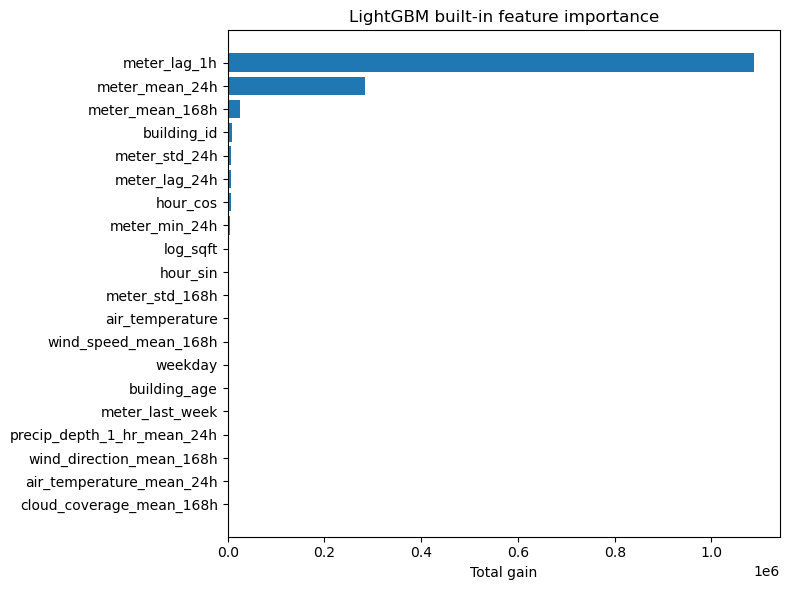

In [ ]:
booster   = lgbm.booster_                    
feat_names = X_train.columns.tolist()

gain  = booster.feature_importance(importance_type="gain")
split = booster.feature_importance(importance_type="split")

imp_df = (
    pd.DataFrame({
        "feature"      : feat_names,
        "gain"         : gain,
        "split_count"  : split
    })
    .sort_values("gain", ascending=False)
)



plt.figure(figsize=(8,6))
plt.barh(imp_df.head(20)["feature"][::-1],
         imp_df.head(20)["gain"][::-1])
plt.xlabel("Total gain")
plt.title("LightGBM built‑in feature importance")
plt.tight_layout()
plt.show()


In [82]:
imp_df

,feature,gain,split_count
43,meter_lag_1h,1.087336e+06,8705
45,meter_mean_24h,2.827646e+05,5643
46,meter_mean_168h,2.551119e+04,2862
54,building_id,9.344548e+03,8730
47,meter_std_24h,7.401267e+03,7347
44,meter_lag_24h,7.387519e+03,5323
1,hour_cos,6.313881e+03,9573
49,meter_min_24h,5.083952e+03,7033
6,log_sqft,3.630095e+03,3411
0,hour_sin,3.152288e+03,7346


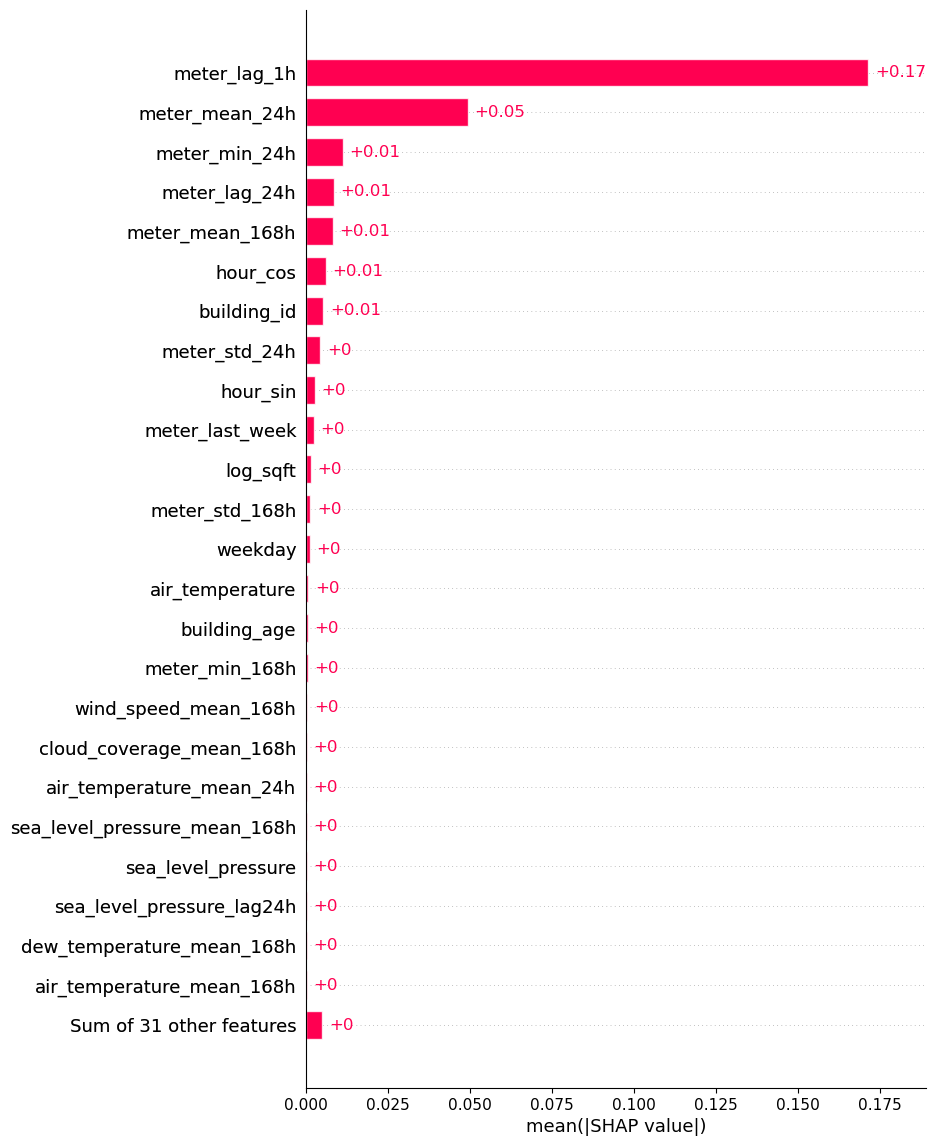

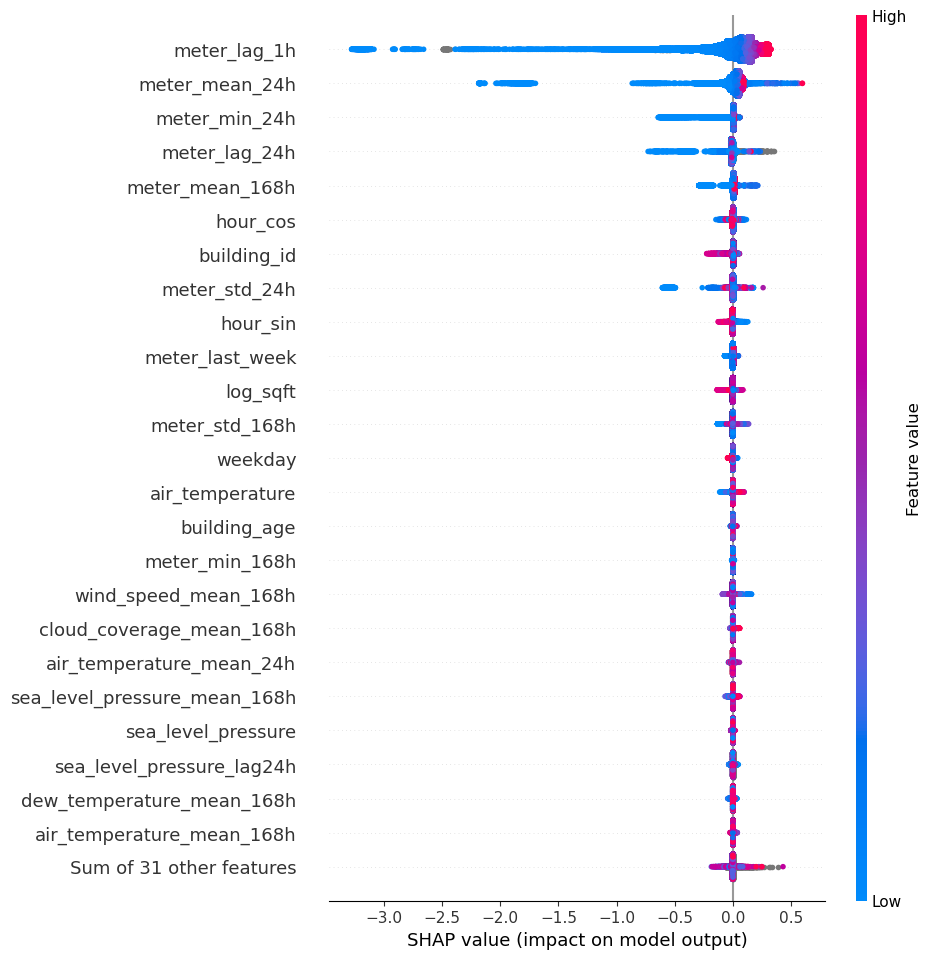

In [ ]:
import shap


explainer   = shap.TreeExplainer(lgbm, model_output="raw")
shap_values = explainer(X_train, check_additivity=False)

shap.plots.bar(shap_values, max_display=25)   # mean |SHAP| top‑25

shap.plots.beeswarm(shap_values, max_display=25)

shap_imp = (
    pd.DataFrame({
        "feature": shap_values.feature_names,
        "mean_abs_shap": np.abs(shap_values.values).mean(0)
    })
    .sort_values("mean_abs_shap", ascending=False)
)
shap_imp.to_csv("shap_global_importance.csv", index=False)


### XGBoost

In [84]:
from scipy import sparse
cat_cols = [
    c for c in X_train.columns if X_train[c].dtype.name == "category" and c not in ["building_id"]
]

pre = ColumnTransformer(
    [("oh", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough",
)

X_train_enc = pre.fit_transform(X_train)
X_val_enc   = pre.transform(X_val)
X_test_enc  = pre.transform(X_test)

X_tune = sparse.vstack(
    [X_train_enc, X_val_enc]
)

y_train_kwh = df.loc[train_mask, "meter_clipped"].values
y_val_kwh   = df.loc[val_mask,   "meter_clipped"].values
y_test_kwh  = df.loc[test_mask,  "meter_clipped"].values

y_tune = np.concatenate([y_train, y_val])
y_tune_kwh = np.concatenate([y_train_kwh, y_val_kwh])
X_tune.shape, y_tune_kwh.shape


((371528, 61), (371528,))

In [85]:
ps = PredefinedSplit( np.r_[ -np.ones(len(y_train)), np.zeros(len(y_val)) ] )
neg_rmse = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)),
                       greater_is_better=False)


In [89]:
base_xgb = xgb.XGBRegressor(
    objective="reg:tweedie", 
    tweedie_variance_power=1.1,
    learning_rate=0.03,
    n_estimators=6000,             
    max_depth=10,
    min_child_weight=30,          
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1, reg_lambda=5,
    enable_categorical=True,       
    early_stopping_rounds=400,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

param_grid = {
    "n_estimators":     [6000, 9000],    
    "learning_rate":    [0.03, 0.05],    
    "max_depth":        [4, 6, 8],
    "min_child_weight": [30, 50],
    "subsample":        [0.8],
    "colsample_bytree": [0.8],
    "gamma":            [0, 1],
    "reg_lambda":       [5, 10],          
}

grid = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    scoring=neg_rmse,
    cv=ps,
    n_jobs=-1,
    # verbose=2,
)

grid.fit(
    X_tune, y_tune,
    eval_set=[(X_val_enc, y_val)],
    verbose=False
)

print("\nBest params :", grid.best_params_,
      "\nBest RMSE_log :", -grid.best_score_)



/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params : {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 50, 'n_estimators': 6000, 'reg_lambda': 5, 'subsample': 0.8} 
Best RMSE_log : -0.2250202970558493


In [90]:
best_xgb = grid.best_estimator_
best_xgb.fit(
    X_train_enc, y_train,
    eval_set=[(X_val_enc, y_val)],
    verbose=False
)

y_hat_log = best_xgb.predict(X_test_enc)
rmse_log_xgb = np.sqrt(mean_squared_error(y_test, y_hat_test))
print(f"XGBoost  RMSE_test log space : {rmse_log_xgb:.2f} kWh")

XGBoost  RMSE_test log space : 0.17 kWh


In [91]:
y_hat = np.expm1(y_hat_log)
y_test_kwh = np.expm1(y_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test_kwh, y_hat))
print(f"XGBoost  RMSE_test : {rmse_xgboost:.2f} kWh")

XGBoost  RMSE_test : 59.10 kWh


In [92]:
with open('./models/xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

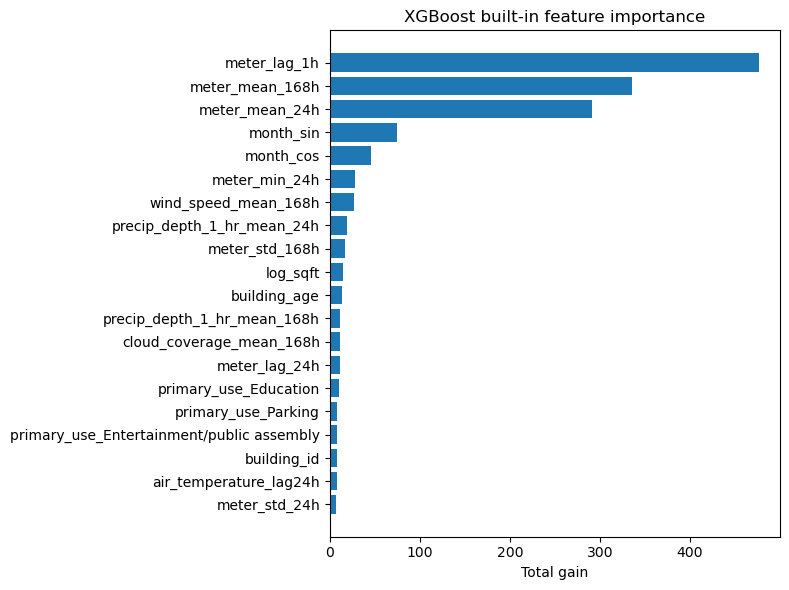

In [103]:
booster = best_xgb.get_booster()


raw_names = pre.get_feature_names_out()
pretty_names    = [name.split("__", 1)[-1] for name in raw_names]

idx2name = {f"f{idx}": pretty_names[idx] for idx in range(len(pretty_names))}

gain_dict = booster.get_score(importance_type="gain")

relabeled = {idx2name[k]: v for k, v in gain_dict.items()}

imp_df = (
    pd.DataFrame(relabeled.items(), columns=["feature", "gain"])
      .sort_values("gain", ascending=False)
)

plt.figure(figsize=(8,6))
plt.barh(imp_df.head(20)["feature"][::-1],
         imp_df.head(20)["gain"][::-1])
plt.xlabel("Total gain")
plt.title("XGBoost built‑in feature importance")
plt.tight_layout(); plt.show()

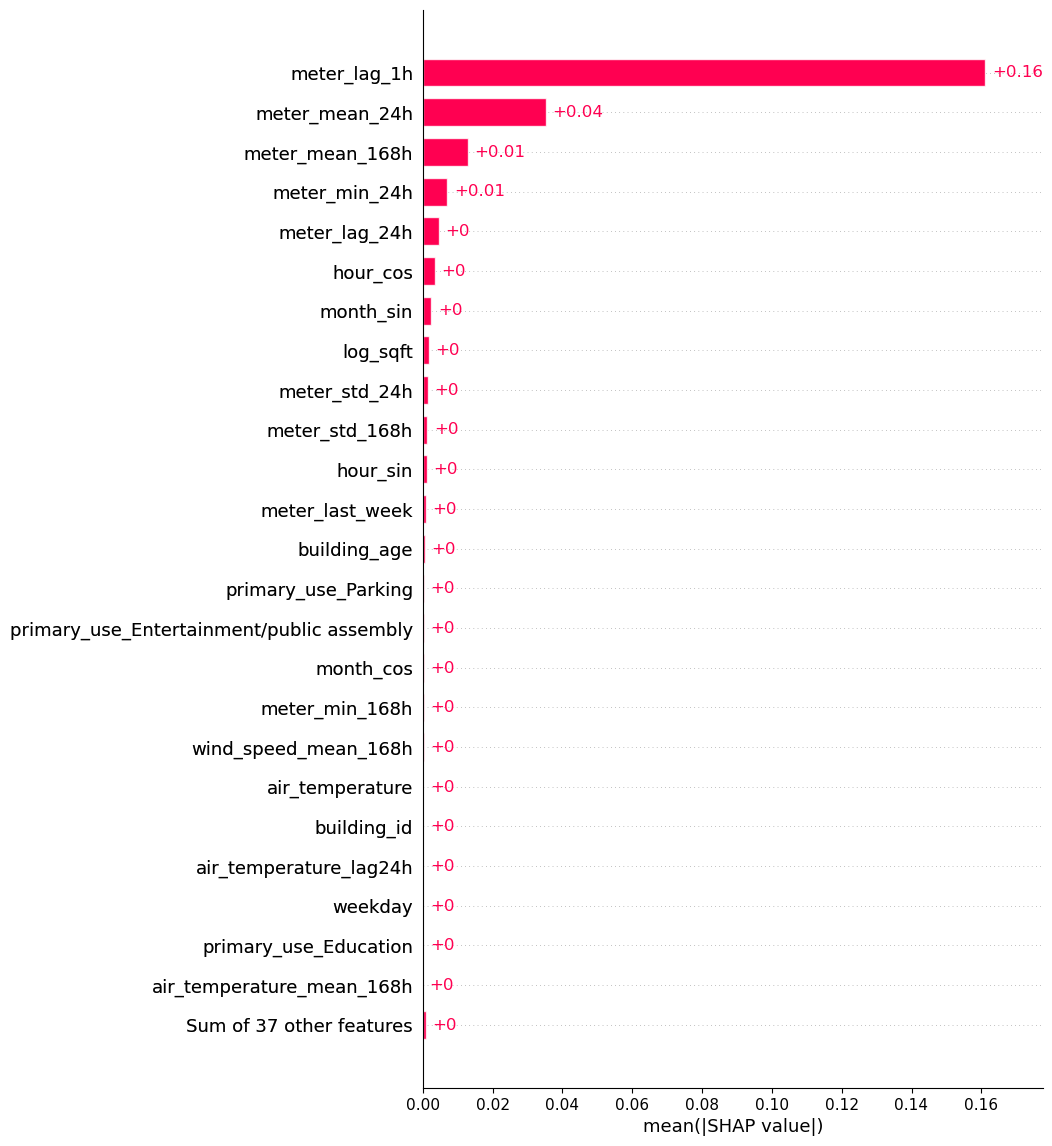

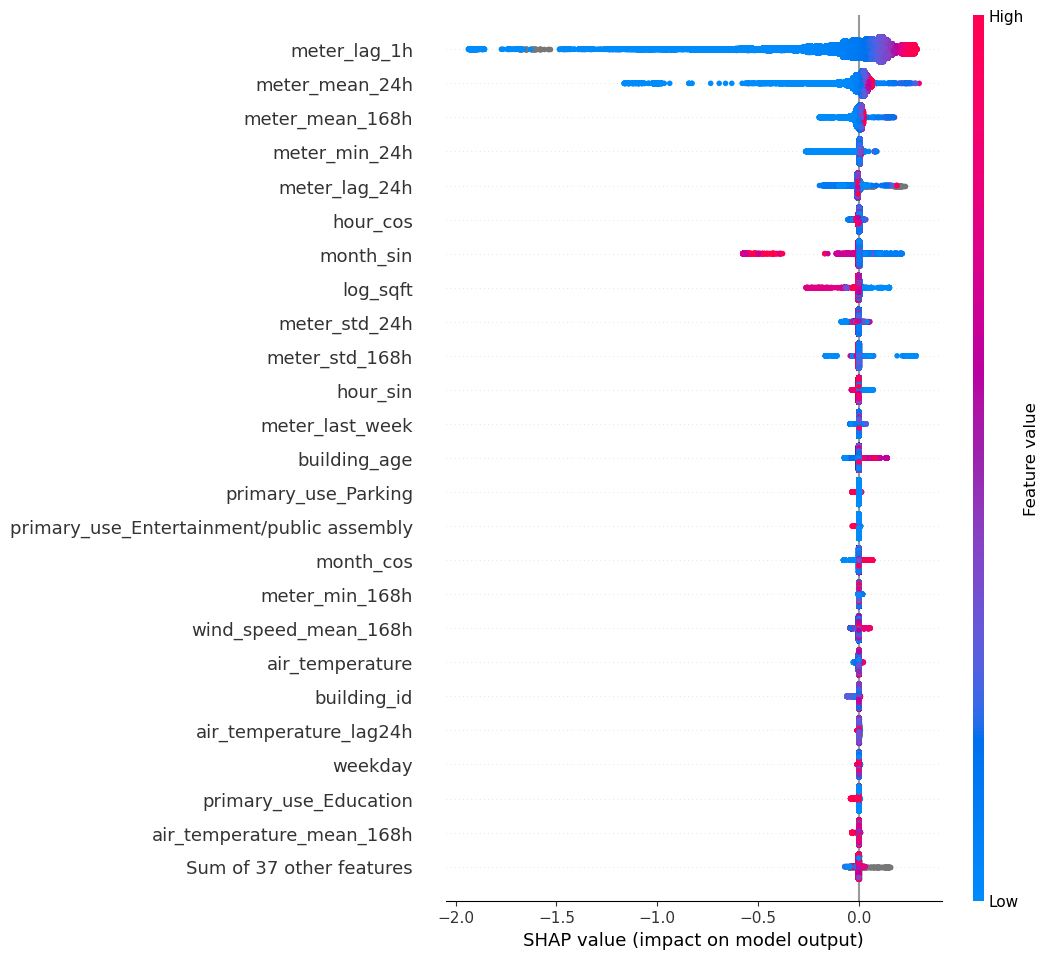

In [108]:
X_train_df = pd.DataFrame(X_train_enc, columns=pretty_names)
explainer   = shap.TreeExplainer(best_xgb, model_output="raw")
shap_values = explainer(X_train_df, check_additivity=False)

shap.plots.bar(shap_values, max_display=25)   # mean |SHAP| top‑25

shap.plots.beeswarm(shap_values, max_display=25)

shap_imp = (
    pd.DataFrame({
        "feature": shap_values.feature_names,
        "mean_abs_shap": np.abs(shap_values.values).mean(0)
    })
    .sort_values("mean_abs_shap", ascending=False)
)
shap_imp.to_csv("shap_global_importance.csv", index=False)


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline

lgb_best_iter = 206                     
lgb_base = lgb.LGBMRegressor(
    objective="tweedie", tweedie_variance_power=1.1,
    n_estimators=lgb_best_iter,         
    learning_rate=0.03, num_leaves=512,
    feature_fraction=0.85, bagging_fraction=0.85, bagging_freq=5,
    min_data_in_leaf=50, random_state=42
)

xgb_params = {
    "colsample_bytree": 0.8,
    "gamma": 1,
    "learning_rate": 0.05,
    "max_depth": 6,
    "min_child_weight": 50,
    "n_estimators": 6000,                
    "reg_lambda": 5,
    "subsample": 0.8,
}
xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror",        
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **xgb_params
)

stack = StackingRegressor(
    estimators=[("lgb", lgb_base), ("xgb", xgb_base)],
    final_estimator=RidgeCV(alphas=np.logspace(-3, 3, 13)),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

model = Pipeline([
    ("prep", pre),
    ("stack", stack)
])

model.fit(X_train, y_train)          

val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

val_rmse  = np.sqrt(mean_squared_error(np.expm1(y_val),  np.expm1(val_pred)))
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(test_pred)))

print(f"Validation RMSE : {val_rmse:.2f} kWh")
print(f"December  RMSE  : {test_rmse:.2f} kWh")


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-thr

In [ ]:
meta_lgb = lgb.LGBMRegressor(
    n_estimators=1000, learning_rate=0.05,
    num_leaves=128, random_state=42
)

stack = StackingRegressor(
    estimators=[("lgb", lgb_base), ("xgb", xgb_base)],
    final_estimator=meta_lgb,
    cv=10,
    passthrough=True,     
    n_jobs=-1
)

model = Pipeline([
    ("prep", pre),
    ("stack", stack)
])

model.fit(X_train, y_train)  

val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

val_rmse  = np.sqrt(mean_squared_error(np.expm1(y_val),  np.expm1(val_pred)))
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(test_pred)))

print(f"Validation RMSE : {val_rmse:.2f} kWh")
print(f"December  RMSE  : {test_rmse:.2f} kWh")
        

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-thr

In [132]:
with open('./models/stack_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [135]:
df

,wind_direction,building_id,timestamp,meter_reading,primary_use,square_feet,year_built,cloud_coverage,air_temperature,dew_temperature,sea_level_pressure,wind_speed,hour,month,precip_depth_1_hr,y_log,meter_clipped,spike_flag,meter_last_week
0,280.0,0,2016-05-20 17:00:00,0.000,Education,7432,2008,6.256104,30.6,22.2,1017.8,2.1,17,5,0.0,0.000000,0.000,0,228.292
78,320.0,0,2016-05-20 18:00:00,232.753,Education,7432,2008,8.000000,25.0,18.3,1017.9,10.3,18,5,-1.0,5.454265,232.753,0,228.292
159,340.0,0,2016-05-20 19:00:00,277.802,Education,7432,2008,5.091603,25.6,18.9,1017.1,5.7,19,5,-1.0,5.630502,277.802,0,228.292
240,30.0,0,2016-05-20 20:00:00,238.896,Education,7432,2008,4.359839,28.3,19.4,1017.0,3.6,20,5,0.0,5.480205,238.896,0,228.292
316,70.0,0,2016-05-20 21:00:00,240.944,Education,7432,2008,3.879151,30.0,18.9,1016.5,5.1,21,5,0.0,5.488706,240.944,0,228.292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430525,120.0,100,2016-12-31 17:00:00,194.939,Lodging/residential,24456,1968,2.000000,20.0,9.4,1023.9,3.6,17,12,0.0,5.277803,194.939,0,177.466
430608,180.0,100,2016-12-31 18:00:00,193.301,Lodging/residential,24456,1968,4.000000,21.7,10.6,1022.7,5.1,18,12,0.0,5.269409,193.301,0,199.308
430842,150.0,100,2016-12-31 21:00:00,188.933,Lodging/residential,24456,1968,2.294647,23.3,10.0,1021.1,4.1,21,12,0.0,5.246671,188.933,0,206.952
430920,160.0,100,2016-12-31 22:00:00,196.577,Lodging/residential,24456,1968,2.506632,22.8,10.0,1021.1,3.1,22,12,0.0,5.286128,196.577,0,212.959
